In [6]:
from bs4 import BeautifulSoup
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import shutil as sh

from webdriver_manager.chrome import ChromeDriverManager
import warnings

import pandas as pd
import numpy as np
import seaborn as sns 

# Getting All Player Links
Scipt to retrieve all player links A-Z

1. Making alphabet list, excluding X becasue no player has a last name that starts with X
2. initialing list to store player links in 

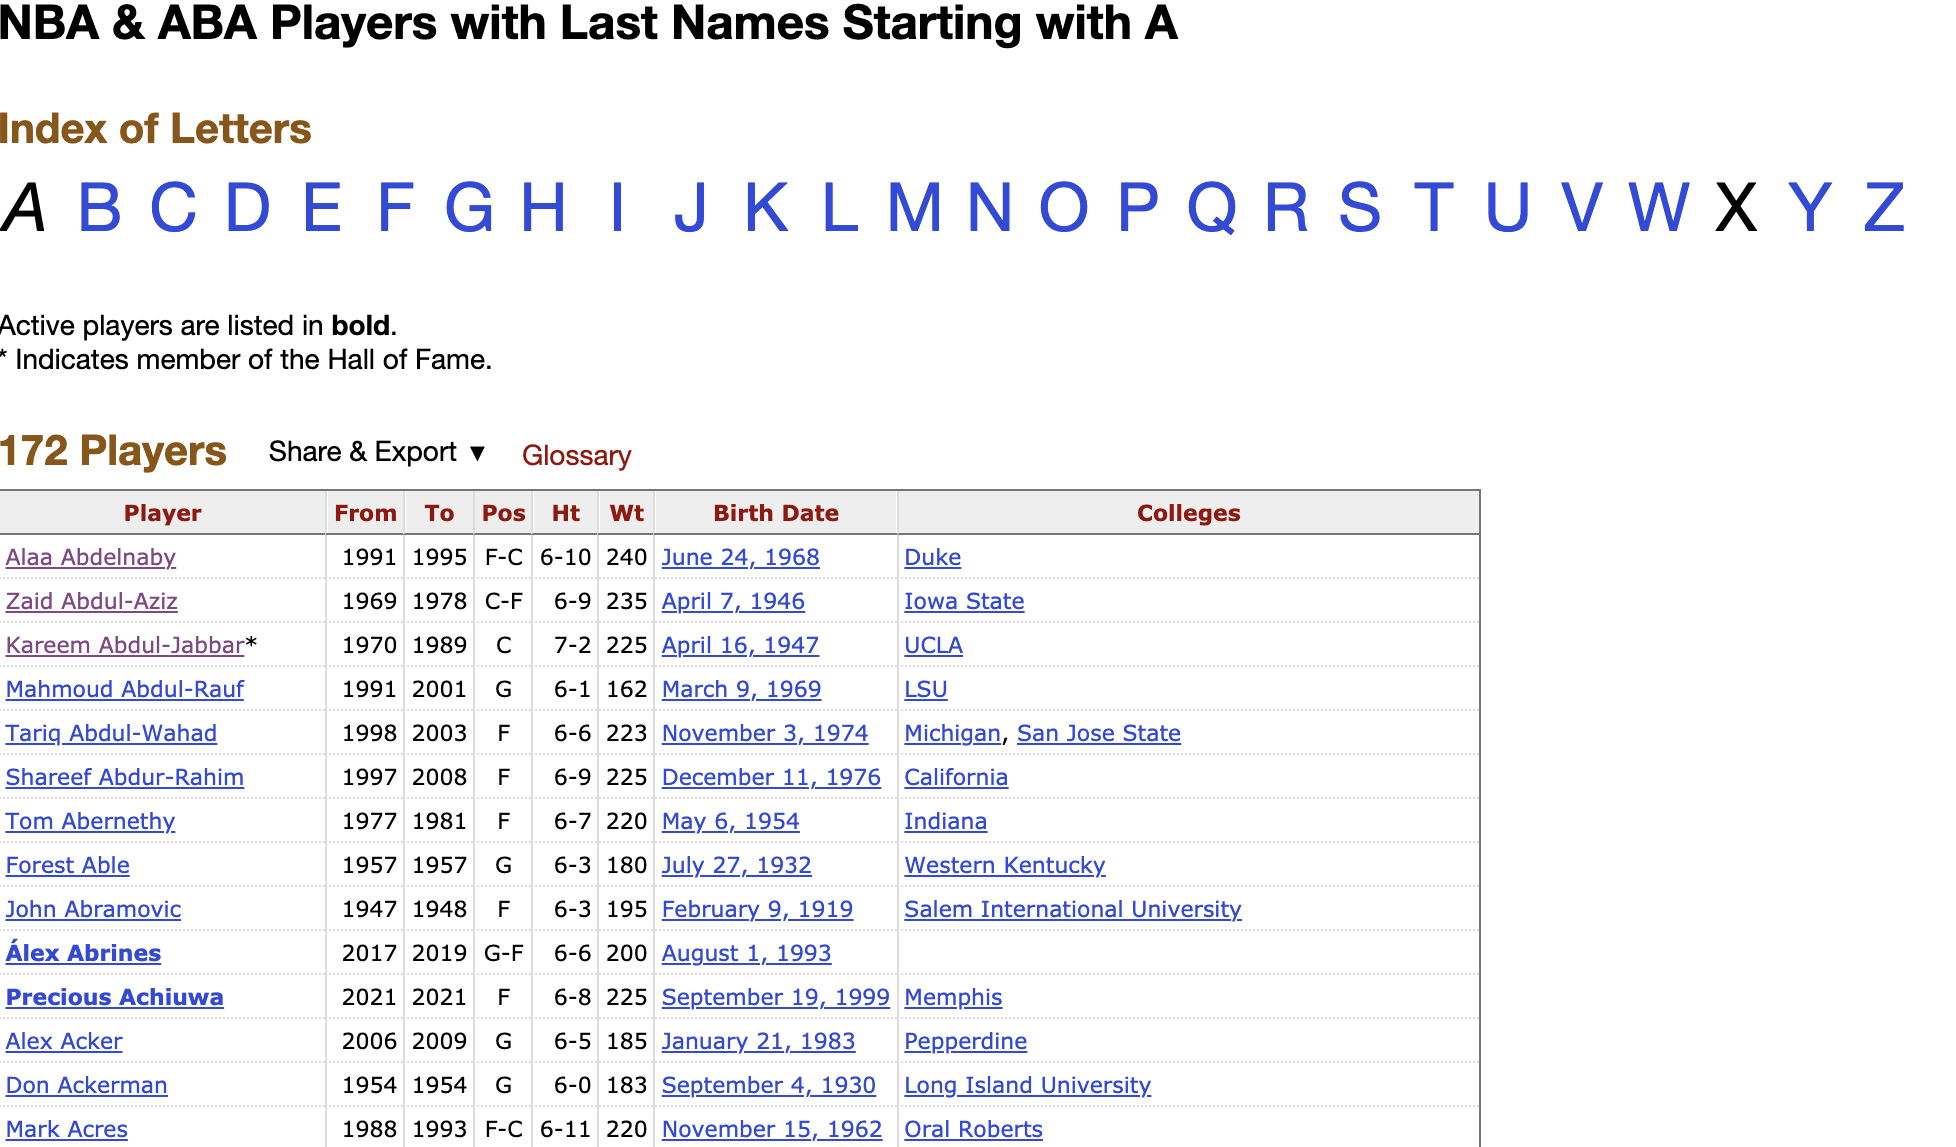


In [623]:
chromedriver = "/Applications/chromedriver" 
os.environ["webdriver.chrome.driver"] = chromedriver
# gettting links for each player page A-Z except X

alpha = ['a','b','c','d','e','f','g',
         'h','i','j','k','l','m','n','o','p',
        'q','r','s','t','u','v','w','y','z']

player_links = []

In [627]:
def get_player_name_links(player_links,alpha):
    for i in range(len(alpha)):
    
        # opening player names list for each letter in alphabet except z
        url = 'https://www.basketball-reference.com/players/{}/'.format(alpha[i])
        base_link = 'https://www.basketball-reference.com/'
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        
        driver = webdriver.Chrome(chromedriver)
        driver.get(url)
        driver.page_source[:]
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
    
        # finding player stats links
        table = soup.find_all('tbody')
        iD = 0
        
        # fixing bug 't_body' length changes every day
        for i in range(len(table)):
            if 'data-stat="player"' in str(table[i]):
                iD = i 
        
        a_tags = table[iD].find_all('a')
        for j in range(len(a_tags)):
            player_stats_link = a_tags[j].attrs['href'].strip('/')
            if 'html' in player_stats_link:
                player_links.append(base_link+player_stats_link)
    
        driver.close()
    
    return player_links
            
player_name_links = get_player_name_links(player_links,alpha)  
  

# Getting Alll Player Stats

Script to get all player stats. Specifically from the advanced stats table

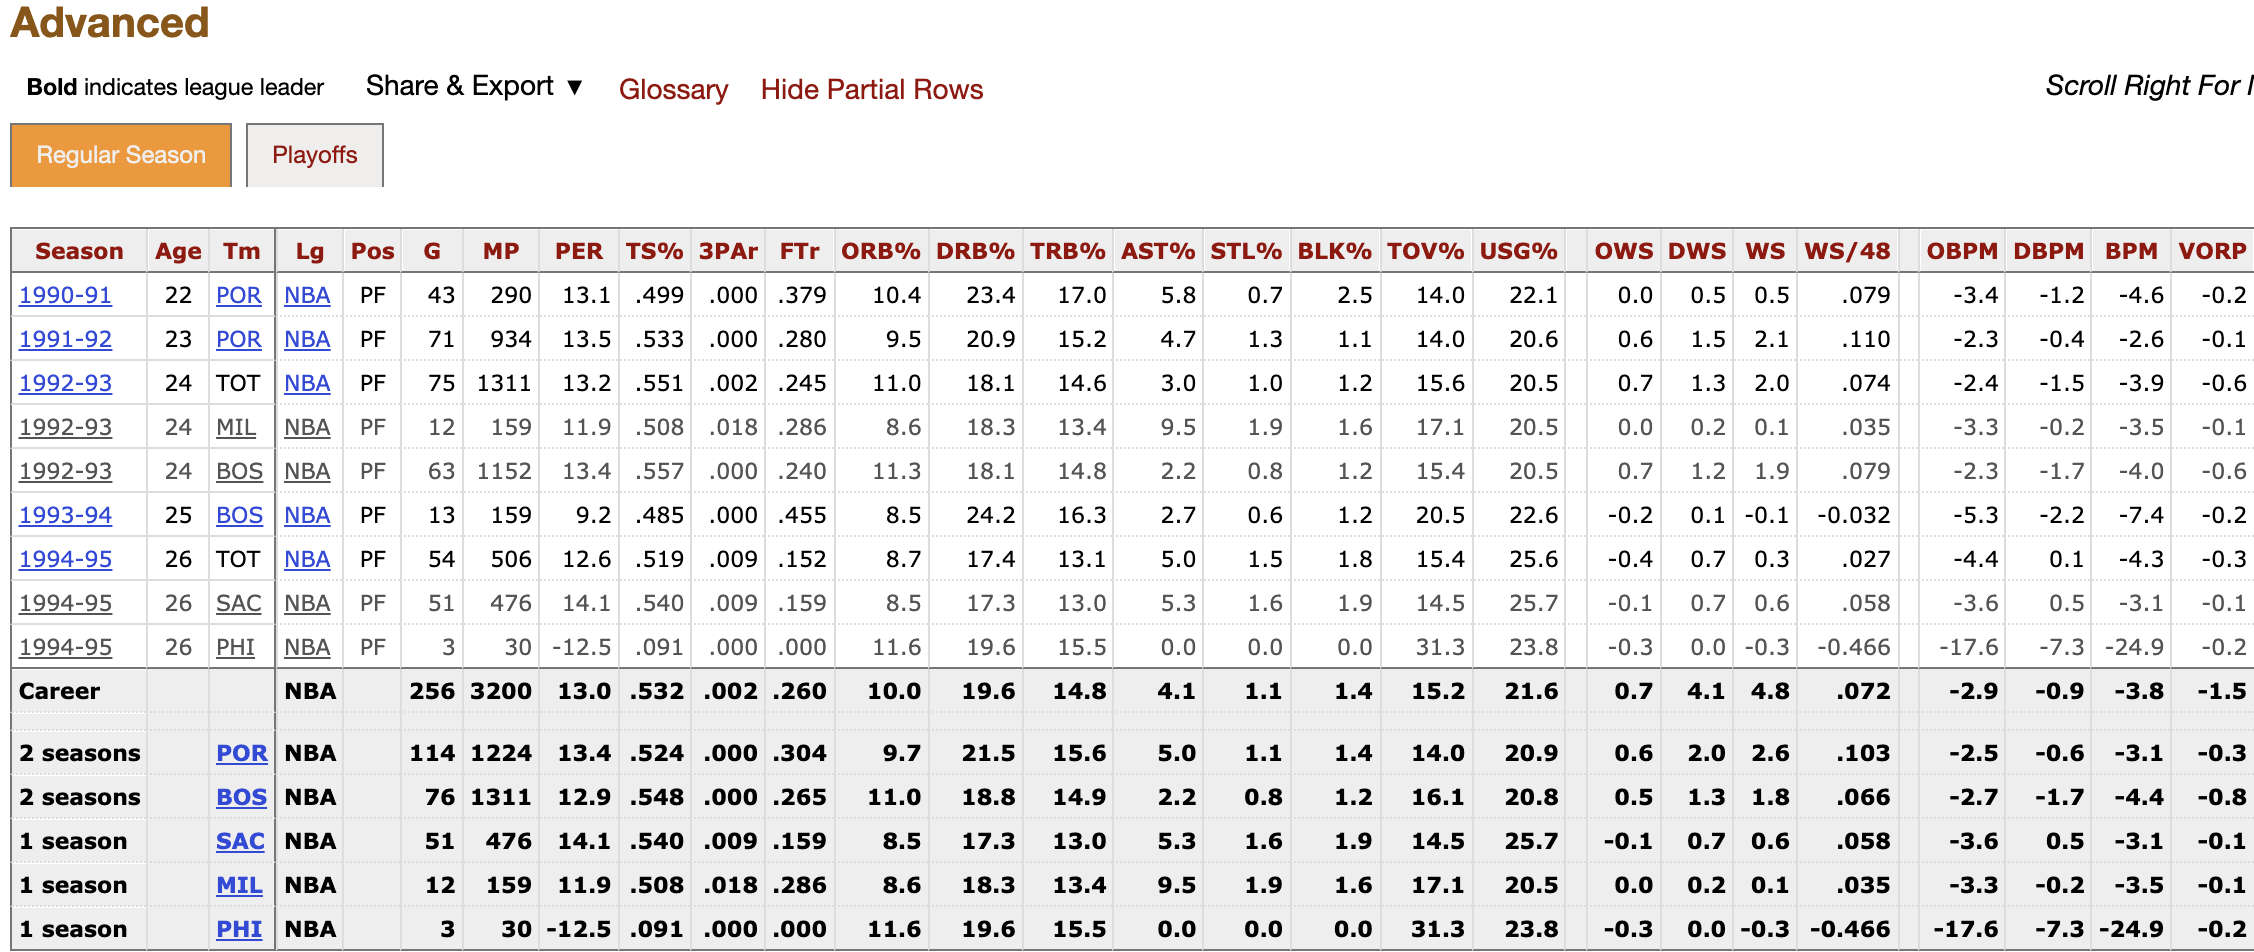

In [571]:
# getting player stats 
def get_player_stats(player_name_links):
    
    STATS = []
    player_dictionary = {}
    names = []
    for i in range(600,1000):
        url = player_name_links[i]
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        
        driver = webdriver.Chrome(chromedriver)
        driver.get(url)
        driver.page_source[:]
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        table = soup.find_all('tbody')
        for i in range(len(table)):
            if 'id="advanced.' in str(table[i].find('tr')):
                iD = i
            
        table_rows = table[iD].find_all('tr')
    
        table_head = table[iD].find_all('th')
        find_name = soup.find('h1')
        name = find_name.text.strip()
        names.append(name)
        year_stats = []
        player_stats = []
        
        for i in range(len(table_rows)):
            year = table_head[i].text
            table_data = table_rows[i].find_all('td')
            year_stats = []
            year_stats.append(year)
            for j in range(len(table_data)):
                if table_data[j].attrs['data-stat'] != 'DUMMY':
                    year_stats.append(table_data[j].text)
            player_stats.append(year_stats)
        
        player_dictionary[name] = player_stats
        
        driver.close()
    
    return player_dictionary,names
        
        
ALL_PLAYERS_STATS,names = player_stats(player_name_links)        

# Preping for type conversion
1. changing all empty strings('') to zeros


In [573]:
# filling empty strings with zero , for type conversion
for key in ALL_PLAYERS_STATS.keys():
    for i in range(len(ALL_PLAYERS_STATS[key])):
        for j in range(len(ALL_PLAYERS_STATS[key][i])):
            if ALL_PLAYERS_STATS[key][i][j] == '':
                ALL_PLAYERS_STATS[key][i][j] = 0
            

# Making Data Frames 

1. Making data frames
2. Only Keeping frames that have 27 columns 
3. Type conversion 

In [574]:
# making player data frames 
player_dataframes = []
for key in ALL_PLAYERS_STATS.keys():
    indexA = []
    indexB = []
    for i in range(len(ALL_PLAYERS_STATS[key])):
        indexA.append(key)
        indexB.append(ALL_PLAYERS_STATS[key][i][0])
    if len(ALL_PLAYERS_STATS[key][0]) == 27: 
        arrays = [np.array(indexA),np.array(indexB)]
        stats = pd.DataFrame(ALL_PLAYERS_STATS[key],index=arrays,columns = ['Season','Age','Team',
                'League','POS','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%',
                'STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM',
                'BPM','VORP'])
        del stats['Season']
        STATS = stats.astype({'Age':'int','Team':'str',
                'League':'str','POS':'str','G':'int','MP':'int',
                'PER':'float','TS%':'float','3PAr':'float','FTr':'float',
                'ORB%':'float','DRB%':'float','TRB%':'float','AST%':'float',
                'STL%':'float','BLK%':'float','TOV%':'float','USG%':'float',
                'OWS':'float','DWS':'float','WS':'float','WS/48':'float',
                'OBPM':'float','DBPM':'float','BPM':'float','VORP':'float'})
        player_dataframes.append(STATS)
    else:
        pass
    
    
    
    
 


In [13]:
next_set = pd.concat(player_dataframes)


In [14]:
Working_Set = pd.concat([first_400,next_set])

In [15]:
Working_Set.to_pickle("WorkingSet")

# Storing Data in SQLite
Using SQL ALchemy 


In [651]:

from sqlalchemy import create_engine

# pickling in data 
WrkSet = pd.read_pickle('WorkingSet')

# instantiating engine
engine = create_engine('sqlite:///NBA.db', echo=True)

# establishing connection to SQLite
sqlite_connection = engine.connect()

2021-06-24 15:16:02,643 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-06-24 15:16:02,644 INFO sqlalchemy.engine.base.Engine ()
2021-06-24 15:16:02,645 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-06-24 15:16:02,645 INFO sqlalchemy.engine.base.Engine ()


In [652]:
# Reading in WrkSet DataFrame into a Table named "Stats" in SQLlite
sqlite_table = "AdvStats"
WrkSet.to_sql(sqlite_table, sqlite_connection, if_exists='fail')

2021-06-24 15:16:09,978 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("AdvStats")
2021-06-24 15:16:09,979 INFO sqlalchemy.engine.base.Engine ()
2021-06-24 15:16:09,980 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("AdvStats")
2021-06-24 15:16:09,981 INFO sqlalchemy.engine.base.Engine ()
2021-06-24 15:16:09,995 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE "AdvStats" (
	level_0 TEXT, 
	level_1 TEXT, 
	"Age" BIGINT, 
	"Team" TEXT, 
	"League" TEXT, 
	"POS" TEXT, 
	"G" BIGINT, 
	"MP" BIGINT, 
	"PER" FLOAT, 
	"TS%" FLOAT, 
	"3PAr" FLOAT, 
	"FTr" FLOAT, 
	"ORB%" FLOAT, 
	"DRB%" FLOAT, 
	"TRB%" FLOAT, 
	"AST%" FLOAT, 
	"STL%" FLOAT, 
	"BLK%" FLOAT, 
	"TOV%" FLOAT, 
	"USG%" FLOAT, 
	"OWS" FLOAT, 
	"DWS" FLOAT, 
	"WS" FLOAT, 
	"WS/48" FLOAT, 
	"OBPM" FLOAT, 
	"DBPM" FLOAT, 
	"BPM" FLOAT, 
	"VORP" FLOAT
)


2021-06-24 15:16:09,996 INFO sqlalchemy.engine.base.Engine ()
2021-06-24 15:16:09,998 INFO sqlalchemy.engine.base.Engine COMMIT
2021-06-24 15:16:09,999 INFO sqlalch

In [653]:
# closing connection
sqlite_connection.close()

# Practicing Pulling Data from SQLite Database

In [18]:
import sqlite3
from sqlalchemy import create_engine

cnx5 = create_engine('sqlite:///NBA.db').connect()
NBA = pd.read_sql('AdvStats', cnx5)
NBA.rename(columns={'level_0': 'PlayerName', 'level_1': 'Year'}, inplace=True)
NBA.set_index(keys=['PlayerName','Year'], drop=True, append=False, inplace=True, verify_integrity=False)

In [21]:
NBA

Age Team League POS   G    MP   PER    TS%   3PAr  \
PlayerName     Year                                                         
Alaa Abdelnaby 1990-91   22  POR    NBA  PF  43   290  13.1  0.499  0.000   
               1991-92   23  POR    NBA  PF  71   934  13.5  0.533  0.000   
               1992-93   24  TOT    NBA  PF  75  1311  13.2  0.551  0.002   
               1992-93   24  MIL    NBA  PF  12   159  11.9  0.508  0.018   
               1992-93   24  BOS    NBA  PF  63  1152  13.4  0.557  0.000   
...                     ...  ...    ...  ..  ..   ...   ...    ...    ...   
Mickey Davis   1972-73   22  MIL    NBA  SF  74  1046  12.2  0.490  0.000   
               1973-74   23  MIL    NBA  SF  73  1012  15.5  0.561  0.000   
               1974-75   24  MIL    NBA  SF  75  1077  14.4  0.530  0.000   
               1975-76   25  MIL    NBA  SF  45   411  12.7  0.445  0.000   
               1976-77   26  MIL    NBA  SF  19   165  16.8  0.513  0.000   

                          FTr  ...  TOV%  USG%  OWS  DWS   WS   WSFE  OBPM  \
PlayerName     Year            ...                                           
Alaa Abdelnaby 1990-91  0.379  ...  14.0  22.1  0.0  0.5  0.5  0.079  -3.4   
               1991-92  0.280  ...  14.0  20.6  0.6  1.5  2.1  0.110  -2.3   
               1992-93  0.245  ...  15.6  20.5  0.7  1.3  2.0  0.074  -2.4   
               1992-93  0.286  ...  17.1  20.5  0.0  0.2  0.1  0.035  -3.3   
               1992-93  0.240  ...  15.4  20.5  0.7  1.2  1.9  0.079  -2.3   
...                       ...  ...   ...   ...  ...  ...  ...    ...   ...   
Mickey Davis   1972-73  0.265  ...   0.0   0.0  0.7  1.6  2.3  0.106   0.0   
               1973-74  0.334  ...   0.0   0.0  2.0  1.3  3.4  0.159   1.1   
               1974-75  0.242  ...   0.0   0.0  1.6  1.0  2.6  0.116   0.2   
               1975-76  0.414  ...   0.0   0.0  0.0  0.3  0.3  0.036  -1.6   
               1976-77  0.368  ...   0.0   0.0  0.3  0.1  0.4  0.102   0.1   

                        DBPM  BPM  VORP  
PlayerName     Year                      
Alaa Abdelnaby 1990-91  -1.2 -4.6  -0.2  
               1991-92  -0.4 -2.6  -0.1  
               1992-93  -1.5 -3.9  -0.6  
               1992-93  -0.2 -3.5  -0.1  
               1992-93  -1.7 -4.0  -0.6  
...                      ...  ...   ...  
Mickey Davis   1972-73   0.0  0.0   0.0  
               1973-74  -0.1  0.9   0.8  
               1974-75  -0.3 -0.2   0.5  
               1975-76  -1.0 -2.6  -0.1  
               1976-77  -0.3 -0.3   0.2  

[3352 rows x 26 columns]